In [1]:
%matplotlib inline
%autosave 60

import sys
sys.path.append('../boresightUtils/')
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from boresightUtils import *
from scipy.optimize import differential_evolution
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic
from scipy.signal import fftconvolve

Autosaving every 60 seconds


In [2]:
# Instrument Specs
focalLengths = [135, 375, 750]
whDegs = [(7.91, 5.93), (2.85, 2.13), (1.42, 1.07)] # Image width and height in Degrees
plateScales = [8.64, 3.11, 1.56] # plate scales of cameras in arcsec / px
whPxs = [convert_fov_degs_px(whDeg, plateScale) for whDeg, plateScale in zip(whDegs, plateScales)]
thresholds = [0.3, 0.1, 0.1]
gSigs = [1, 4, 4]

# Notebook Configurables
camNum = 0 # Choose an instrument
figsDir = os.path.expanduser('~/Pictures/work/lsst/startracker/simulate_drift') # Where to save the figures
fitsDir = os.path.expanduser("~/DATA/sitcom/starTracker/findBoresight/arcImages") # Where to write the fits files
saveFig = True

# Parameters Derived / Selected from Configurables
focalLength = focalLengths[camNum]
plateScale = plateScales[camNum]
width, height = whPxs[camNum]
gaussianBlurSigma = gSigs[camNum]
threshold = thresholds[camNum]
xMu = width / 2 
yMu = height / 2

In [3]:
# Drift calibration
driftSpeedArcSec = 0 # arcseconds / s
driftDir = np.array([[1], [0]]) # Drifting right in px space initially
driftVel = driftSpeedArcSec / (plateScale) * driftDir # Drift in px / s
nStars = 25

ims = []
thetaInits = [0, 0]
driftTimes = [0, 180]

seed = 1000 # 98735927 # Set a seed (optional)

for i, (thetaInit, driftTime) in enumerate(zip(thetaInits, driftTimes)):
    # numpy random Stuff
    if seed is None:
        rng = np.random.default_rng() # Make one of these things
    else:
        rng = np.random.default_rng(seed)

    # Dictionary of Configurables to pass to functions
    configDict = {
        'expTime': 0,
        'slewRate': 6,
        'driftVel': driftVel,
        'threshold': threshold,
        'rng': rng,
        'imageWidth': width,
        'imageHeight': height,
        'gaussianBlurSigma': gaussianBlurSigma,
        'xMu': xMu,
        'yMu': yMu,
        'pointingSigma': 300,
        'nStars': nStars,
        }
    
    arcImg, pointingCenter = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)
    ims.append(arcImg)

In [4]:
im0 = gaussian_blur_image(ims[0], configDict)
im1 = gaussian_blur_image(ims[1], configDict)

In [5]:
totalDrift = measure_drift(im0, im1)
driftRateRC = totalDrift / driftTimes[1]
driftRate = np.array([[driftRateRC[1]], [-driftRateRC[0]]])
print(driftRate)
print(driftVel)
print(driftRate - driftVel)

[[ 0.]
 [-0.]]
[[0.]
 [0.]]
[[ 0.]
 [-0.]]


In [6]:
configDict = {
    'expTime': 15,
    'slewRate': 6,
    'driftVel': driftRate,
    'threshold': threshold,
    'rng': rng,
    'imageWidth': width,
    'imageHeight': height,
    'gaussianBlurSigma': gaussianBlurSigma,
    'xMu': xMu,
    'yMu': yMu,
    'pointingSigma': 0,
    'nStars': nStars,
    }

arcImg, trueBoresight = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)

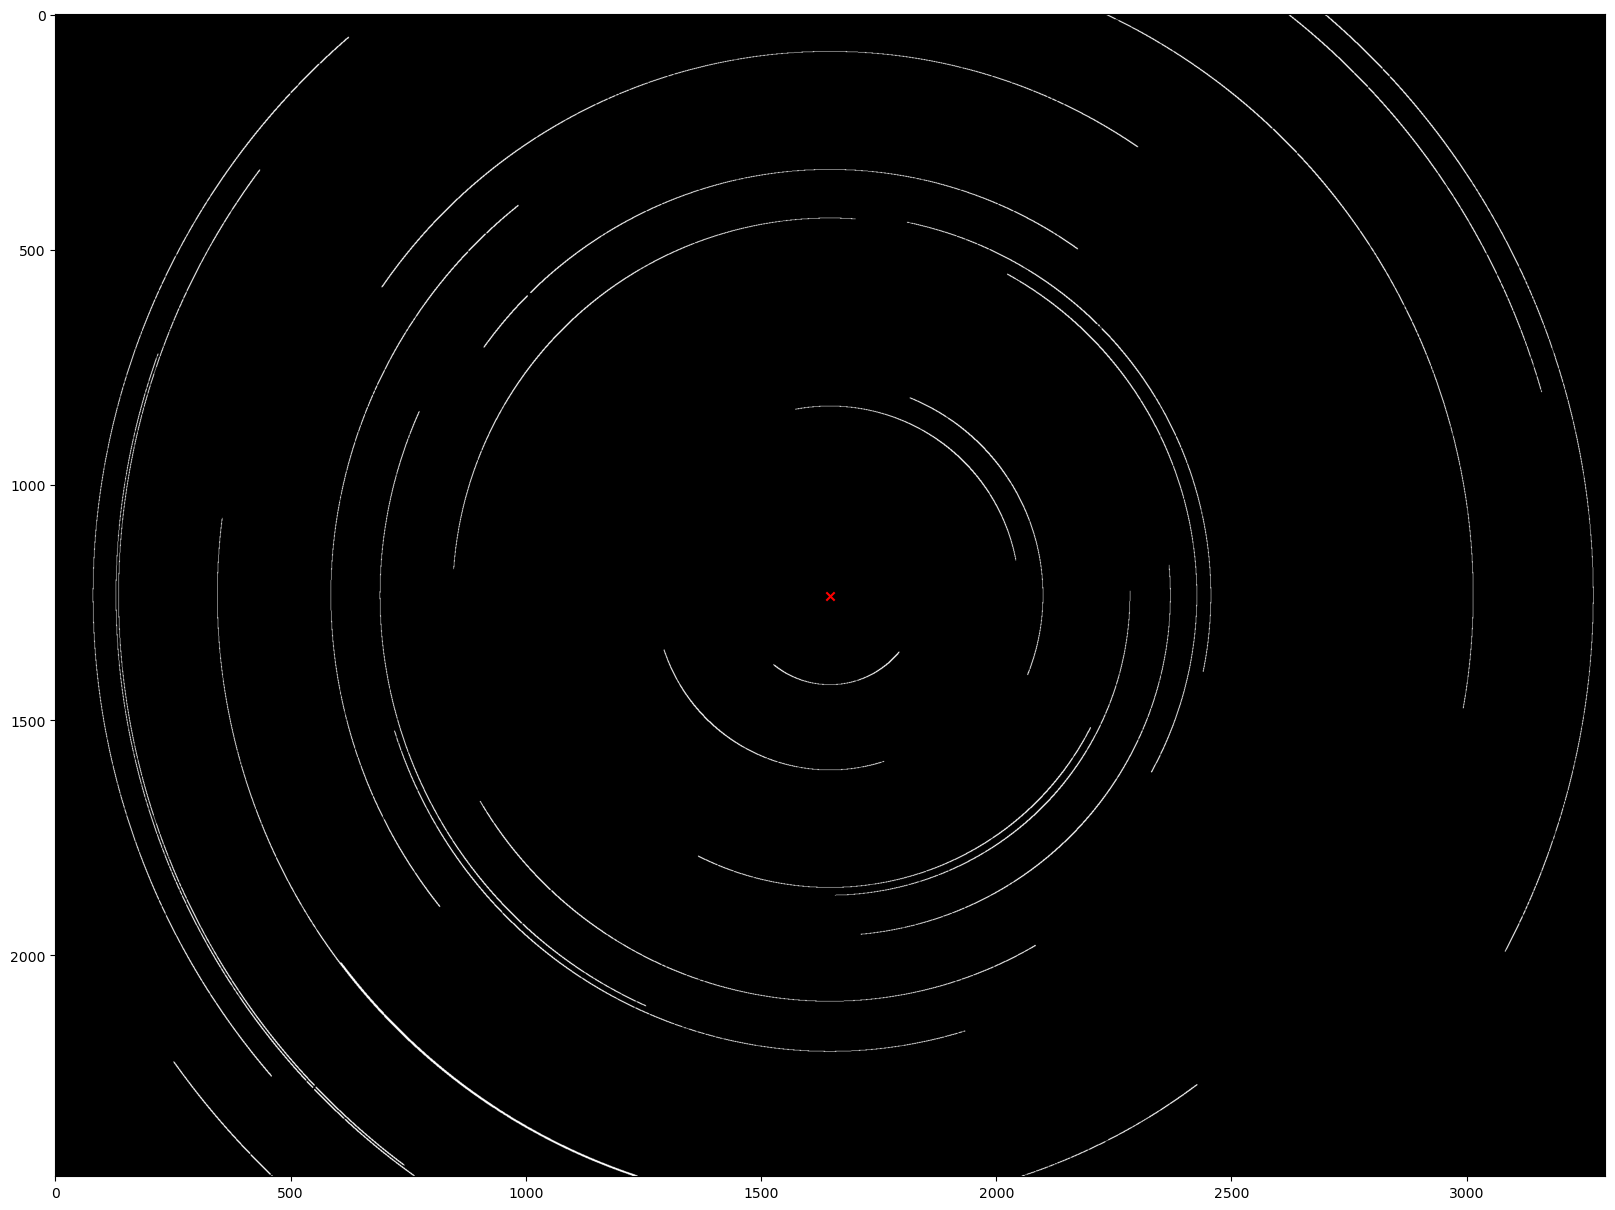

In [7]:
blurredImg = gaussian_blur_image(arcImg, configDict)
bpxs = make_threshold_image(arcImg, configDict)
plot_arc_image(bpxs, boresight=trueBoresight)

In [8]:
hdu = fits.PrimaryHDU(arcImg)
hdul = fits.HDUList([hdu])
arcImgFileName = os.path.join(fitsDir, "arcImg.fits")
hdul.writeto(arcImgFileName, overwrite=True)

In [9]:
streaks = find_streaks(arcImgFileName)

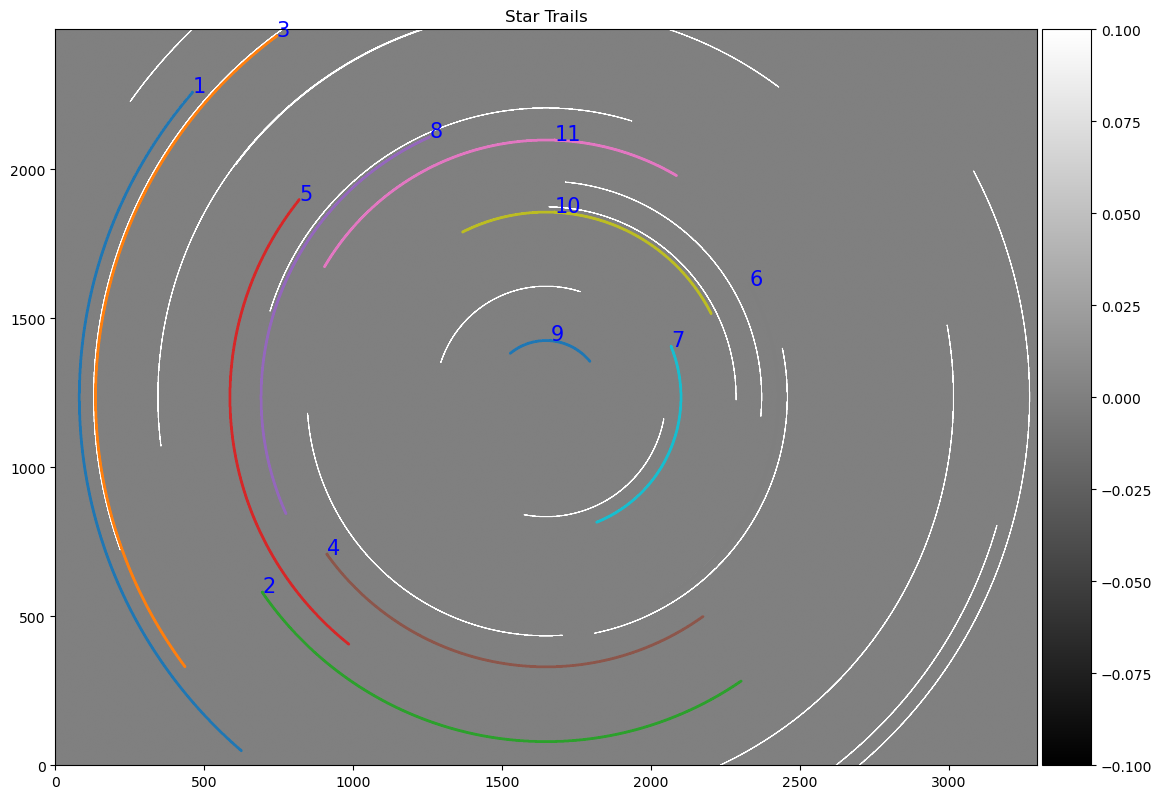

In [10]:
plot_streaks(arcImgFileName, streaks)

In [13]:
centerDict = findStreaksCenter(streaks)
center = np.array([centerDict['x'], centerDict['y']])
print(center, trueBoresight)

[1647.00871383 1235.00499509] [1647.5 1235. ]


In [18]:
nTrials = 10
boresights = np.zeros((nTrials, 2))

for iTrial in range(nTrials):
    boresightRC = find_boresight_naive(bpxs)
    boresights[iTrial] = xy_image_coord_transform(boresightRC, bpxs, inverse=True)

In [21]:
boresight = boresights.mean(axis=0)
print(boresight)

[1647.02581693 1235.00002346]


In [ ]:
trueBoresightIdx = xy_image_coord_transform(trueBoresight, bpxs)
print(boresight, trueBoresightIdx, boresight - trueBoresightIdx)

[1231.20365637 2136.06952277] [1230.58861958 2136.73176742] [ 0.61503679 -0.66224464]


In [6]:
pointingList = [(3*width/4, 3*height/4), (3*width/4, 1*height/4), (1*width/4, 1*height/4), (1*width/4, 3*height/4)]
nTrials = 10
biases = np.zeros((len(pointingList), nTrials, 2))

for iPointing, (xMu, yMu) in enumerate(pointingList):

    biases[iPointing] = calculate_drift_bias(configDict, nTrials=nTrials)